### Start

In [355]:
def encode(df):
    le = preprocessing.LabelEncoder()
    le.fit(df)
    return(le.transform(df))

def normalize(df):
    return pd.Series(df).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ','_').str.lower().str.strip().tolist()    

In [356]:
def clean(df, ano):
    df = df.drop(columns=['Unnamed: 16'])
    df.columns = normalize(df.columns)
    mask = df['orgao'].notnull()
    df = df[mask]
    
    for col in df.columns[-6:]:
        df[col] = df[col].str.replace('.','').str.replace(',','.')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    categoria = {
        '3' :  'DESPESAS CORRENTES',
        '4' :  'DESPESAS DE CAPITAL',
        '9' :  'RESERVA DE CONTINGENCIA',
    }
    
    df['categoria'] = df['elemento'].apply(lambda x: x[:1]).replace(categoria)

    
    grupo = {
        '31' : 'PESSOAL E ENCARGOS SOCIAIS',
        '32' : 'JUROS E ENCARGOS DA DIVIDA',
        '33' : 'OUTRAS DESPESAS CORRENTES',
        '44' : 'INVESTIMENTOS',
        '45' : 'INVERSOES FINANCEIRAS',
        '46' : 'AMORTIZACAO DE DIVIDA',
        '99' : 'RESERVA DE CONTINGENCIA'
    }
    
    df['grupo'] = df['elemento'].apply(lambda x: x[:2]).replace(grupo)
    
    modalidade = {
        '3120' :  'TRANSFERENCIAS A UNIAO',
        '3190' :  'APLICACOES DIRETAS',
        '3191' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIA',
        '3290' :  'APLICACOES DIRETAS',
        '3291' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '3320' :  'TRANSFERENCIAS A UNIAO',
        '3340' :  'TRANSFERENCIAS A MUNICIPIOS',
        '3341' :  'TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO',
        '3350' :  'TRANSF.A INST.PRIVADAS SEM FINS LUCRATIVOS',
        '3360' :  'TRANSF.A INST.PRIVADAS COM FINS LUCRATIVOS',
        '3367' :  'EXECUCAO DE CONTRATO DE PPP',
        '3370' :  'TRANSF.A INSTIT.MULTIGOVERN.NACIONAIS',
        '3380' :  'TRANSFERENCIAS AO EXTERIOR',
        '3390' :  'APLICACOES DIRETAS',
        '3391' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4420' :  'TRANSFERENCIAS A UNIAO',
        '4440' :  'TRANSFERENCIAS A MUNICIPIOS',
        '4450' :  'TRANSF.A INSTIT.PRIVADAS SEM FINS LUCRATIVOS',
        '4490' :  'APLICACOES DIRETAS',
        '4491' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4567' :  'EXECUCAO DE CONTRATO DE PPP',
        '4590' :  'APLICACOES DIRETAS',
        '4591' :  'APLIC.DIRETAS-OP.ENTRE ENTID.INTEGR.ORCAMENT',
        '4690' :  'APLICACOES DIRETAS',
        '4691' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '9999' :  'RESERVA DE CONTINGENCIA',

    }
    
    df['modalidade'] = df['elemento'].apply(lambda x: x[:4]).replace(modalidade)

    
    
    return(df)

### PIE Plot

In [357]:
def pie_plot(dd,label='orgao',value='valor'):
    labels = dd[label]
    values = dd[value]
    trace = go.Pie(
        labels=labels,
        values=values,
        hoverinfo='label+percent+value',
        textinfo='label+percent',
        opacity = 0.90,
        textposition='outside',
#         textposition='auto',

        marker=dict(
            line=dict(
                color='#000000',
                width=1)
        ),
    )

    layout =  dict(
        height = 300,
    #         width = 1200,
        font = dict(
          size = 10
        ),    
    )


    fig = go.Figure(data=[trace], layout=layout)
    fig.show()



### Sankey Plot

In [358]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

### Perfil Historico

In [359]:
# mater df
df_final = pd.DataFrame()

##################################################### 2010-2019 #####################################################

#years to get
anos = [str(i) for i in range(2010,2020)]

for ano in anos:
    #read year by year
    df = pd.read_csv('../data/orcamento/orcamento_{}.csv'.format(ano), encoding="ISO-8859-9")
    df_18 = clean(df,ano)

    #padronizer
    df_18['elemento'] = df_18['elemento'].str.split('-').apply(lambda x: x[1]).str.strip()
    df_18['orgao'] = df_18['orgao'].str.split('-').apply(lambda x: x[1]).str.strip()
    df_18['ano']=ano
    
    #append to final df
    df_final = pd.concat([df_final,df_18], axis=0)

#just fell cols
cols = ['ano','orgao','unidade_gestora','fonte_de_recursos','programa','acao','grupo','dotacao_inicial']
df_total = df_final[cols]

##################################################### 2020 #####################################################

#get LOA FROM 2020 
ano = '2020'
#read file
df = pd.read_excel('../data/orcamento/orcamento_{}.xlsx'.format(ano), encoding="utf-8")
#normalize columns
df.columns = normalize(df.columns)
df_20 = df.copy()
#normalize orgaos
df_20['orgao'] = df_20['orgao'].str.split('-').apply(lambda x: x[1]).str.strip()
df_20['orgao'] = normalize(df_20['orgao'])
df_20['orgao'] = df_20['orgao'].str.replace('_',' ').str.upper()
#normalize grupos
df_20['grupo'] = df_20['grupo'].str.replace('INVESTIMENTOS','INVESTIMENTO').str.replace('INVESTIMENTO','INVESTIMENTOS').str.upper().str.strip()
df_20['grupo'] = normalize(df_20['grupo'])
df_20['grupo'] = df_20['grupo'].str.replace('_',' ').str.upper()
#create some columns
df_20['total'] = 'TOTAL'
df_20['programa']=df_20['programa'].apply(lambda x: x[18:]).str.strip()
df_20['ano'] = '2020'
#filter just some columns
cols = ['ano','orgao','unidade_gestora','fonte_de_recursos','programa','acao','grupo','dotacao_inicial']
df_20_f = df_20[cols]

##################################################### ALL YEARS #####################################################

#create a df with all years
df_total = pd.concat([df_total,df_20_f], axis=0)

#normalize grupo and remove anomalys
df_total['grupo'] = df_total['grupo'].str.replace('AMORTIZACAO DE DIVIDA','AMORTIZACAO DA DIVIDA').str.replace('AMORTIZACAO DA DIVIDA','JUROS E ENCARGOS DA DIVIDA')
mask = df_total['grupo']!='34'
df_total = df_total[mask]

##################################################### MAP ORGAOS #####################################################
#map the diferent orgaos
orgaos_match = pd.read_excel('../data/aux/orgaos_match.xlsx')
df = pd.merge(df_total,orgaos_match, left_on='orgao',right_on='old', how='left')

#grop aux cols
df['orgao'] = df['new']
df = df.drop(columns=['old','new'])
df = df.rename(columns={'dotacao_inicial':'valor'})

In [360]:
df['mean'] = df['valor']
for ano in df.ano.unique().tolist():
    mask = df['ano']==ano
    total = df[mask]['valor'].sum()
    df['mean'] = np.where(mask, df['valor']/total, df['mean'])
    
df['percent'] =  round(df['mean']*100,2)
df['vbi'] =  round(df['valor']/10**9,2)

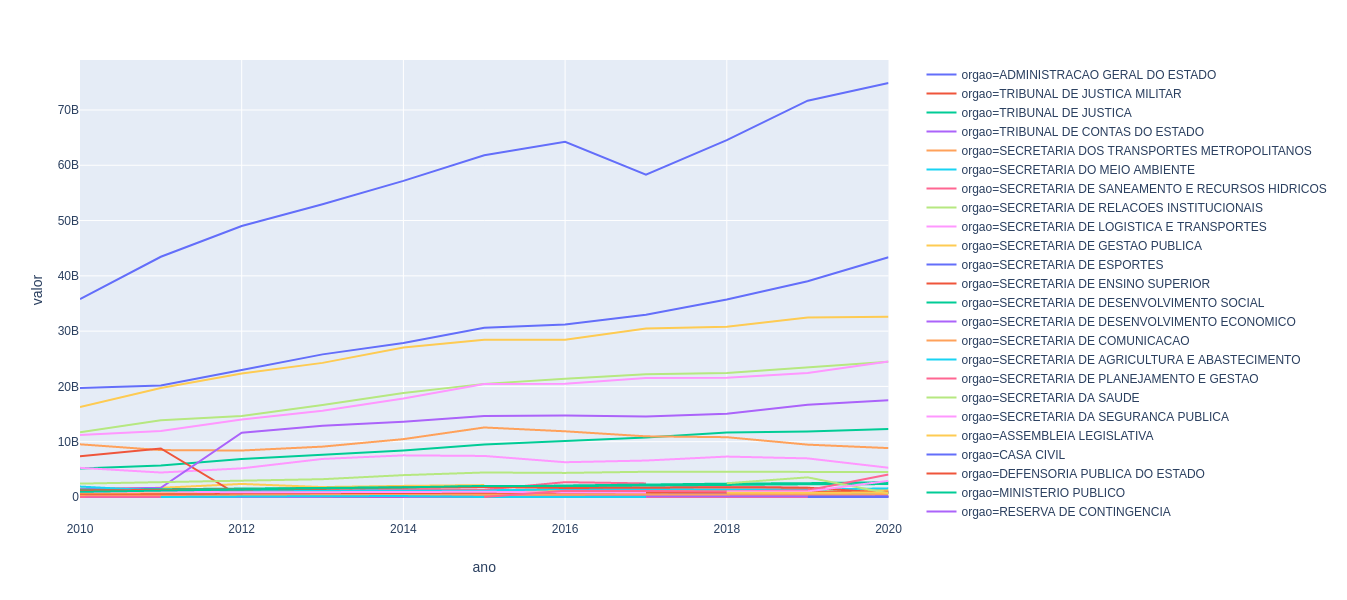

In [361]:
dd = df.groupby(by=['ano','orgao'], as_index=False).sum().sort_values(by='ano')

# mask = (dd['percent']>7)
px.line(dd, x='ano', y='valor', color='orgao')


In [362]:

dd = df.groupby(by=['ano','grupo'], as_index=False).sum().sort_values(by='ano')
# px.area(dd, x='ano', y='percent', color='grupo')


In [363]:
dd = df.groupby(by=['ano','orgao'], as_index=False).sum().sort_values(by='ano')
dd['ano'] = dd['ano'].astype(int)


mask = (dd['percent']>7) & (dd['ano']>2013)
dd = dd[mask]

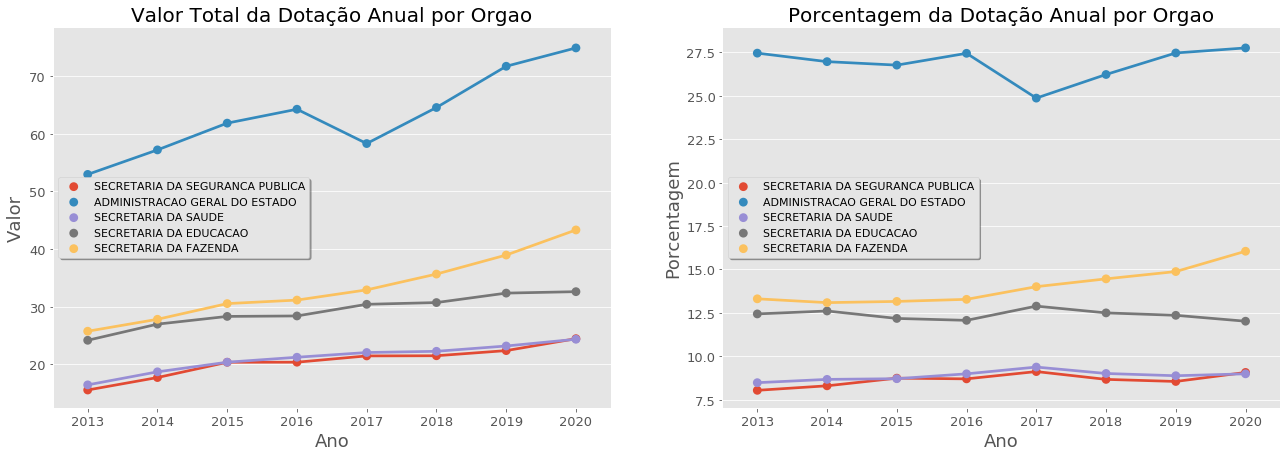

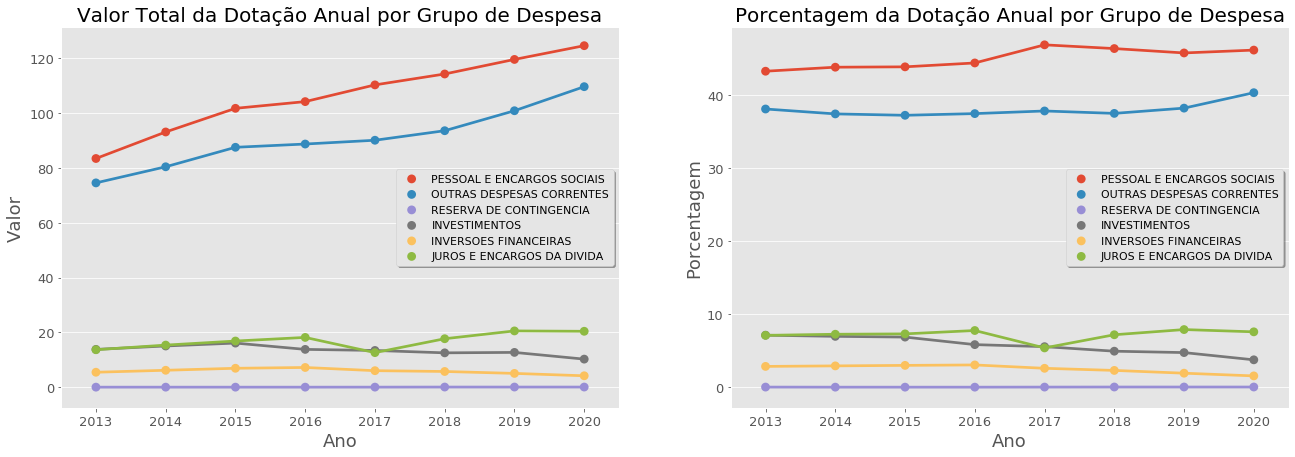

In [364]:
#################### ORGAO ####################
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

dd = df.groupby(by=['ano','orgao'], as_index=False).sum().sort_values(by='ano')
dd['ano'] = dd['ano'].astype(int)
mask = (dd['percent']>7) & (dd['ano']>=2013)
dd = dd[mask]

title_size  = 20
legend_size = 11
label_size  = 18
axis_size   = 13


plt.style.use('ggplot')
fig = plt.figure(figsize=(22,7))

ax2 = fig.add_subplot(1,2,1)
ax2.set_title("Valor Total da Dotação Anual por Orgao", fontsize=title_size)
sns.pointplot(data = dd[mask],x='ano',y='vbi', hue='orgao',ax=ax2)
plt.legend(loc='best',fancybox=True, frameon=True, shadow=True, fontsize=legend_size)
ax2.set_xlabel("Ano",fontsize=label_size)
ax2.set_ylabel("Valor",fontsize=label_size)
ax2.tick_params(labelsize=axis_size)

ax = fig.add_subplot(1,2,2)
ax.set_title("Porcentagem da Dotação Anual por Orgao", fontsize=title_size)
sns.pointplot(data = dd[mask],x='ano',y='percent', hue='orgao',ax=ax)
plt.legend(loc='best',fancybox=True, frameon=True, shadow=True, fontsize=legend_size)
ax.set_xlabel("Ano",fontsize=label_size)
ax.set_ylabel("Porcentagem",fontsize=label_size)
ax.tick_params(labelsize=axis_size)

fig.savefig('../images/orgao_historico.png')


#################### GRUPO ####################
dd = df.groupby(by=['ano','grupo'], as_index=False).sum().sort_values(by='ano')
dd['ano'] = dd['ano'].astype(int)
mask = (dd['ano']>=2013)
dd = dd[mask]


plt.style.use('ggplot')
fig = plt.figure(figsize=(22,7))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Valor Total da Dotação Anual por Grupo de Despesa", fontsize=title_size)
sns.pointplot(data = dd,x='ano',y='vbi', hue='grupo',ax=ax1)
plt.legend(loc='best',fancybox=True, frameon=True, shadow=True, fontsize=legend_size)
ax1.set_xlabel("Ano",fontsize=label_size)
ax1.set_ylabel("Valor",fontsize=label_size)
ax1.tick_params(labelsize=axis_size)

ax = fig.add_subplot(1,2,2)
ax.set_title("Porcentagem da Dotação Anual por Grupo de Despesa", fontsize=title_size)
sns.pointplot(data = dd,x='ano',y='percent', hue='grupo',ax=ax)
plt.legend(loc='best',fancybox=True, frameon=True, shadow=True, fontsize=legend_size)
ax.set_xlabel("Ano",fontsize=label_size)
ax.set_ylabel("Porcentagem",fontsize=label_size)
ax.tick_params(labelsize=axis_size)

fig.savefig('../images/grupo_historico.png')


## Perfil Anual

In [365]:
mask = df['ano']=='2020'
df_ano          = df[mask]
df_ano['total'] = 'ORCAMENTO TOTAL'


mask = df['ano']=='2019'
df_19          = df[mask]
df_19['total'] = 'ORCAMENTO TOTAL'

### Bar

### GERAL

In [367]:
def bar_plot(dd, label='orgao', value='valor',title="titulo"):
    trace1 = go.Bar(
        x=dd[value], 
        y="<b>" + dd[label] + "</b>",
        orientation='h',
        marker=dict(
            color='rgb(250, 118, 9)',
            line=dict(color='rgb(13, 72, 90)', width=2)
        ),
        hoverlabel = dict(
            font = dict(
                size=22
            )
        )

    )

    layout = go.Layout(

        yaxis = dict(
            tickfont=dict(
                size=13,
                color='black',
            )
        ),
        
        xaxis = dict(
            tickfont=dict(
                size=18,
                color='black',
            )
        ),
        
        title=dict(
            text=title,
            x=0.6,
            y=0.9,
            xanchor='center',
            yanchor='top',
            font = dict(
                size=22,
            )
        ),
        
        height = 800,
        
    #     width = 1200
    )

    data = [trace1]

    fig = go.Figure(data=data, layout=layout)
    fig.show()
    
    return(fig)

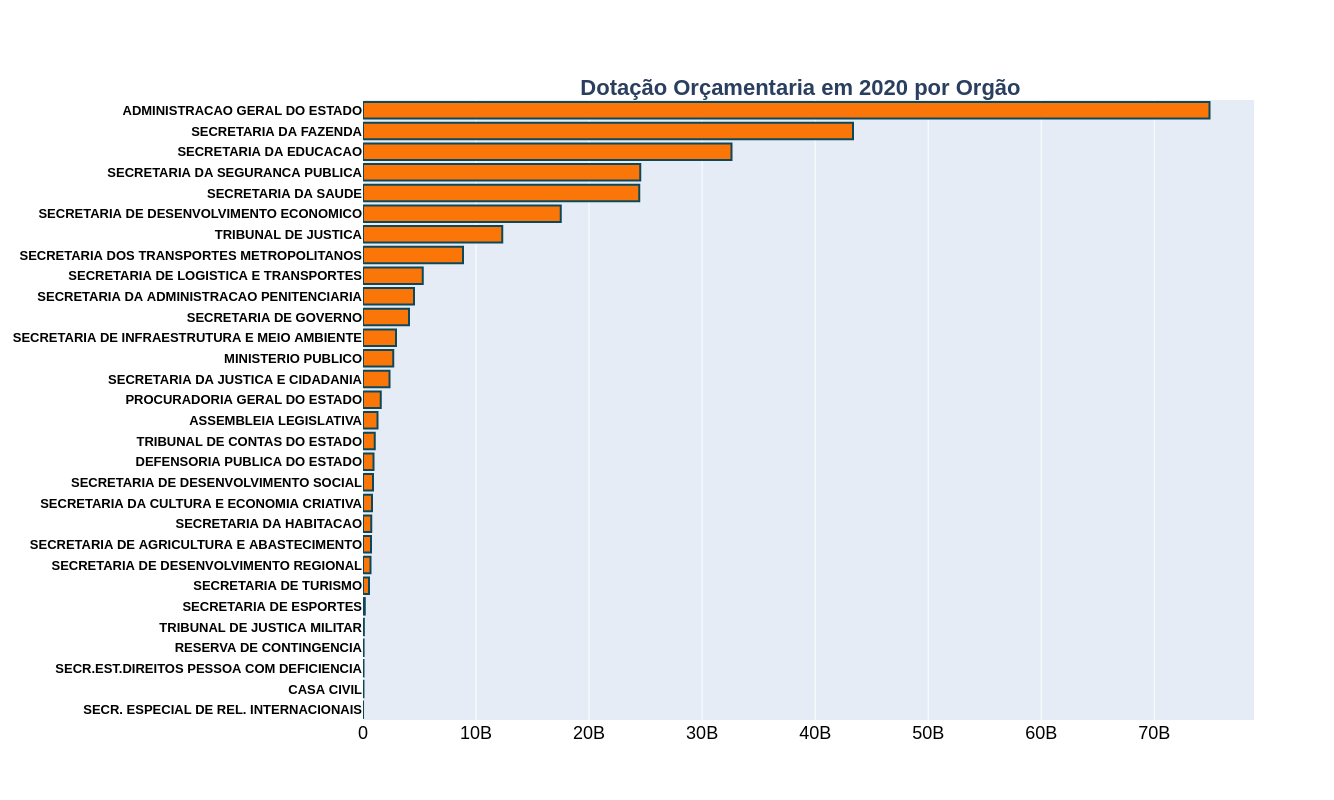

In [368]:
dd = df_ano.groupby(by='orgao', as_index=False).sum()
# dd['valor'] = round(dd['valor'],2)

# # pie_plot(dd)
dd = dd.sort_values(by='valor')


title = '<b>Dotação Orçamentaria em 2020 por Orgão</b>'

fig = bar_plot(dd,title=title)

# plot(fig, filename="../images/orcamento_2020_por_orgao.html", auto_open=False)

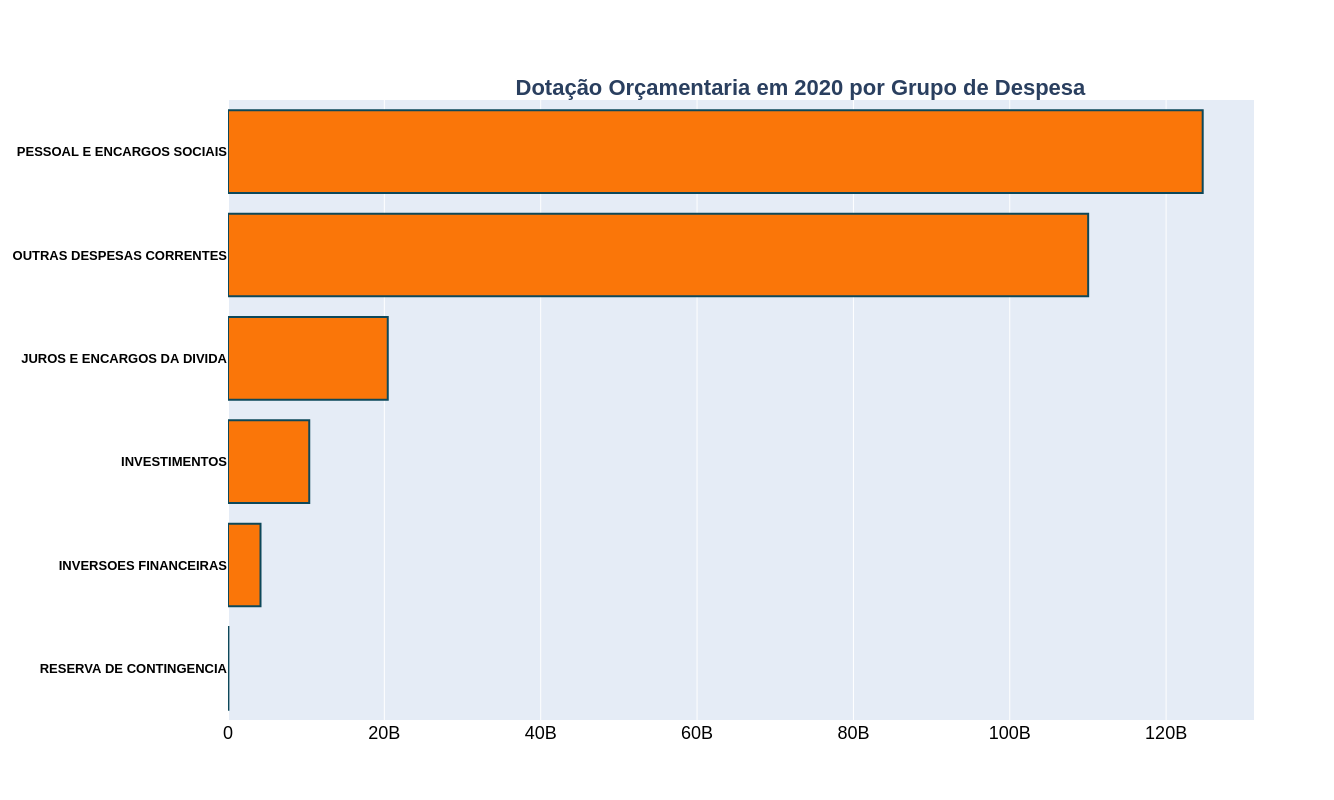

In [369]:
dd = df_ano.groupby(by='grupo', as_index=False).sum()
dd = dd.sort_values(by='valor')

title = '<b>Dotação Orçamentaria em 2020 por Grupo de Despesa</b>'

fig = bar_plot(dd, label='grupo', title=title)
# plot(fig, filename="../images/orcamento_2020_por_grupo.html", auto_open=False)

### Sankey

In [400]:
def sankey_plot(df_18,source,target,valor,xx=[],yy=[]):
    cols = source + target
    cols = list(set(cols))

    df_sankey = df_18.groupby(by = cols, as_index=False, sort=False).sum()[cols + [valor]]
    color = '#300101'

    df_sankey = df_sankey.sort_values(by=cols)
    
    
    df_final = pd.DataFrame()

    for i in range(len(source)):
        df_aux = pd.DataFrame()

        print(source[i], target[i])


        df_aux['source'] = df_sankey[source[i]]
        df_aux['target'] = df_sankey[target[i]]
        df_aux['value']  = df_sankey[valor]
        df_final = pd.concat([df_final,df_aux], axis=0)
        
    label = df_final['source'].tolist() + df_final['target'].tolist()
    # value = df_sankey['orgaos_count'].tolist() + df_sankey['grupo_count'].tolist()
    df = pd.DataFrame(label,columns = ['label'])
    # df['number'] = value
    df = df.drop_duplicates(subset='label', keep='first')
    df['number'] = [i for i in range(len(df))]
    
    df_final = pd.merge(df_final,df, left_on = ['source'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'source_num'})
    df_final = pd.merge(df_final,df, left_on = ['target'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'target_num'})
    
    
    
#     df['group'] = np.nan
#     for col in cols:
#         mask = df['label'].isin(df_18[col].unique())
#         df['group'] = np.where(mask,col,df['group'])
#     larg=1300
#     x_dist = 1/len(df['group'].unique())
    
#     n_dict = df['group'].value_counts().to_dict()
#     xx = []
#     i=0
#     factors=[0.1,0.3,0.95]
    
#     for grup in df['group'].unique():
#         number=n_dict[grup]
#         xi = [factors[i] for j in range(int(number))]
#         xx = xx + xi
#         i+=1
        
    ####plot####
    
    
    df_final['link']="value:" + df_final['value'].astype(str)
    
    trace1 = go.Sankey(
        orientation='h',
        arrangement = "freeform",
        
        domain={
            'x':[0,1],
            'y':[0,1],
        },
        
        node = {
            "label"     : df['label'],
            "x":xx,
            'y':yy,
            'pad'       : 10,
            'thickness' : 50,
            'line' : {
                'width' : 2,
            },
            'hoverinfo' : "all",
            
            'hoverlabel':{
                'font':{
                    'size':15
                }
            } 
            
        },  # 10 Pixels 

        
        
        link = {
            'source' : df_final['source_num'],
            'target' : df_final['target_num'],
            'value' : df_final['value'],
            'label' : df_final['link'],
            
            'hoverlabel':{
                'font':{
                    'size':15
                }
            }
        },
        
#         textfont={
#             "size":1,
#         },
        
        
        
        
    )
    
    layout =  dict(
        height = 900,
#         width = larg,
        font = dict(
          size = 10
        ),    
    )
    
    fig = go.Figure(data = trace1, layout=layout)
    
    iplot(fig) 
    return(fig)



In [418]:
mask = df_ano['orgao']=='MINISTERIO PUBLICO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx=[]
yy=[]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/mpsp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/mpsp.html", auto_open=False)

In [397]:
# cols = ['orgaos','unidade','programas','acao']
source = ['orgao']
target = ['grupo']
valor  = 'valor'
xx=[]
yy=[]
# fig= sankey_plot(df_ano,source,target,valor,xx,yy)

# plot(fig, filename="../images/sankey/orgao_e_grupo.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/orgao_e_grupo.html", auto_open=False)

In [372]:
# cols = ['orgaos','unidade','programas','acao']
source = ['total']
target = ['orgao']
valor  = 'valor'

# sankey_plot(df_ano,source,target,valor)

### ADM GERAL

In [384]:
mask = df_ano['orgao']=='ADMINISTRACAO GERAL DO ESTADO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

# fig =  sankey_plot(educacao,source,target,valor)



# plot(fig, filename="../images/sankey/adm_geral_estado.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/adm_geral_estado.html", auto_open=False)

### Alesp

In [385]:
mask = df_ano['orgao']=='ASSEMBLEIA LEGISLATIVA'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx=[]
yy=[]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/alesp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/alesp.html", auto_open=False)

### TCESP

In [413]:
mask = df_ano['orgao']=='TRIBUNAL DE CONTAS DO ESTADO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx=[]
yy=[]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/tcesp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/tcesp.html", auto_open=False)

### MPSP

In [ ]:
mask = df_ano['orgao']=='MINISTERIO PUBLICO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx=[]
yy=[]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/mpsp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/mpsp.html", auto_open=False)

### TJSP

In [407]:
mask = df_ano['orgao']=='TRIBUNAL DE CONTAS DO ESTADO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx=[]
yy=[]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/tjsp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/tjsp.html", auto_open=False)

### Educacao

In [386]:
mask = df_ano['orgao']=='SECRETARIA DA EDUCACAO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

xx=[0,0.3,0.3,0.3]
yy=[0,0.5,0.65,0.28]

# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/educacao.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/educacao.html", auto_open=False)

### Saude

In [387]:
mask = df_ano['orgao']=='SECRETARIA DA SAUDE'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx = [0, 0.3 , 0.3, 0.3, 0.3]
yy = [0, 0.3, 0.49, 0.56, 0.6]
# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/saude.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/saude.html", auto_open=False)

### Seguranca

orgao grupo
grupo acao


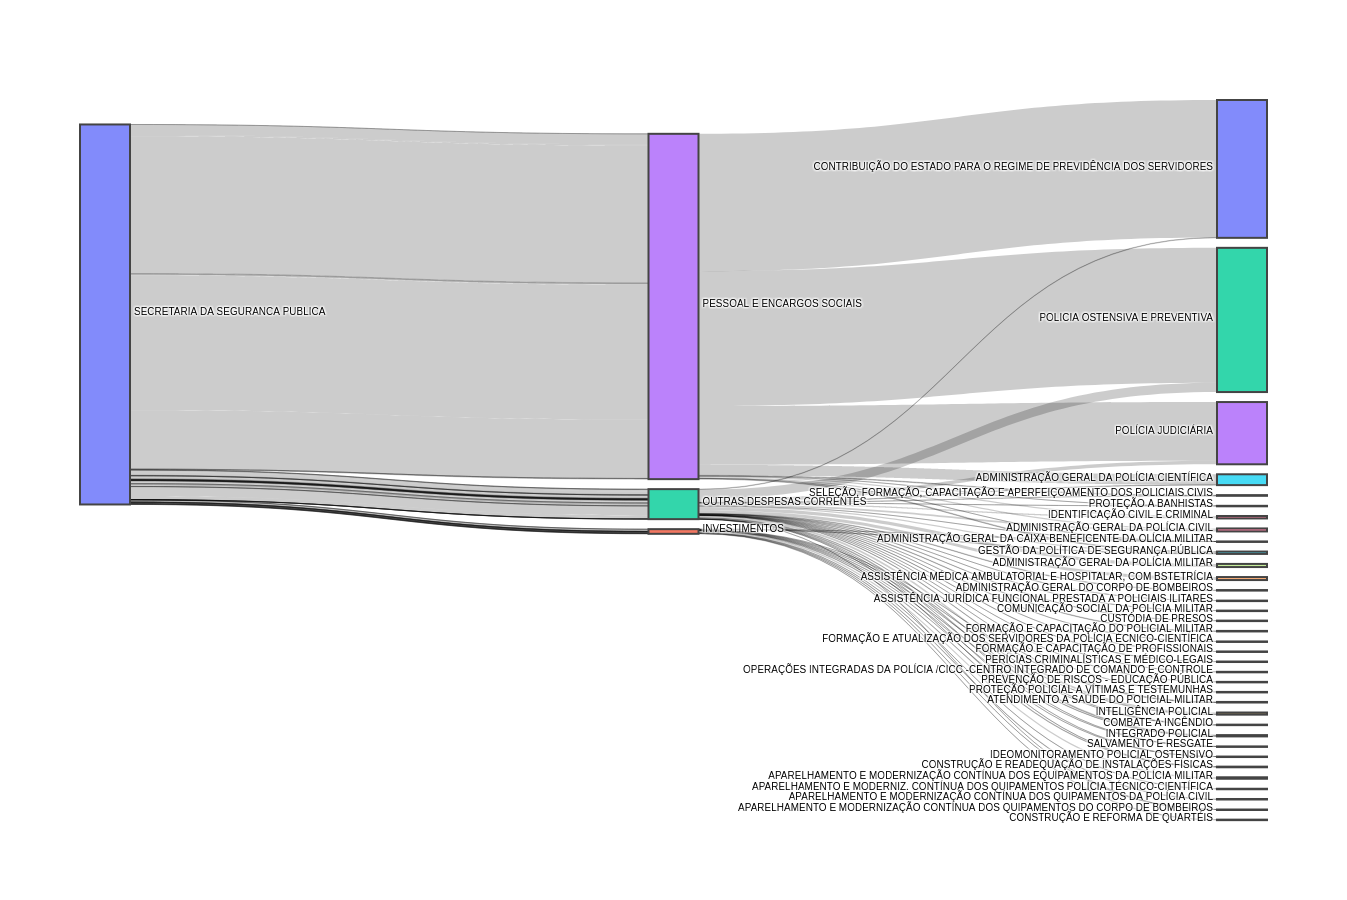

In [425]:
mask = df_ano['orgao']=='SECRETARIA DA SEGURANCA PUBLICA'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


# xx = [0.05, 0.3 , 0.3, 0.3]
# yy = [0.5, 0.37+0.3, 0.4+0.3,0.19+0.3]
xx=[]
yy=[]
fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/ssp.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/ssp.html", auto_open=False)

### Previdencia

In [417]:
dd = df_ano.copy()
mask = (dd['programa'].str.contains('PREVI')) | (dd['acao'].str.contains('PREVI'))
educacao = dd[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'


xx = []
yy = []
# fig =  sankey_plot(educacao,source,target,valor,xx,yy)



# plot(fig, filename="../images/sankey/previdencia.html", auto_open=False)
# plot(fig, filename="../../sample_pages/images/orcamento/previdencia.html", auto_open=False)

### Transparencia

orgao grupo
grupo programa


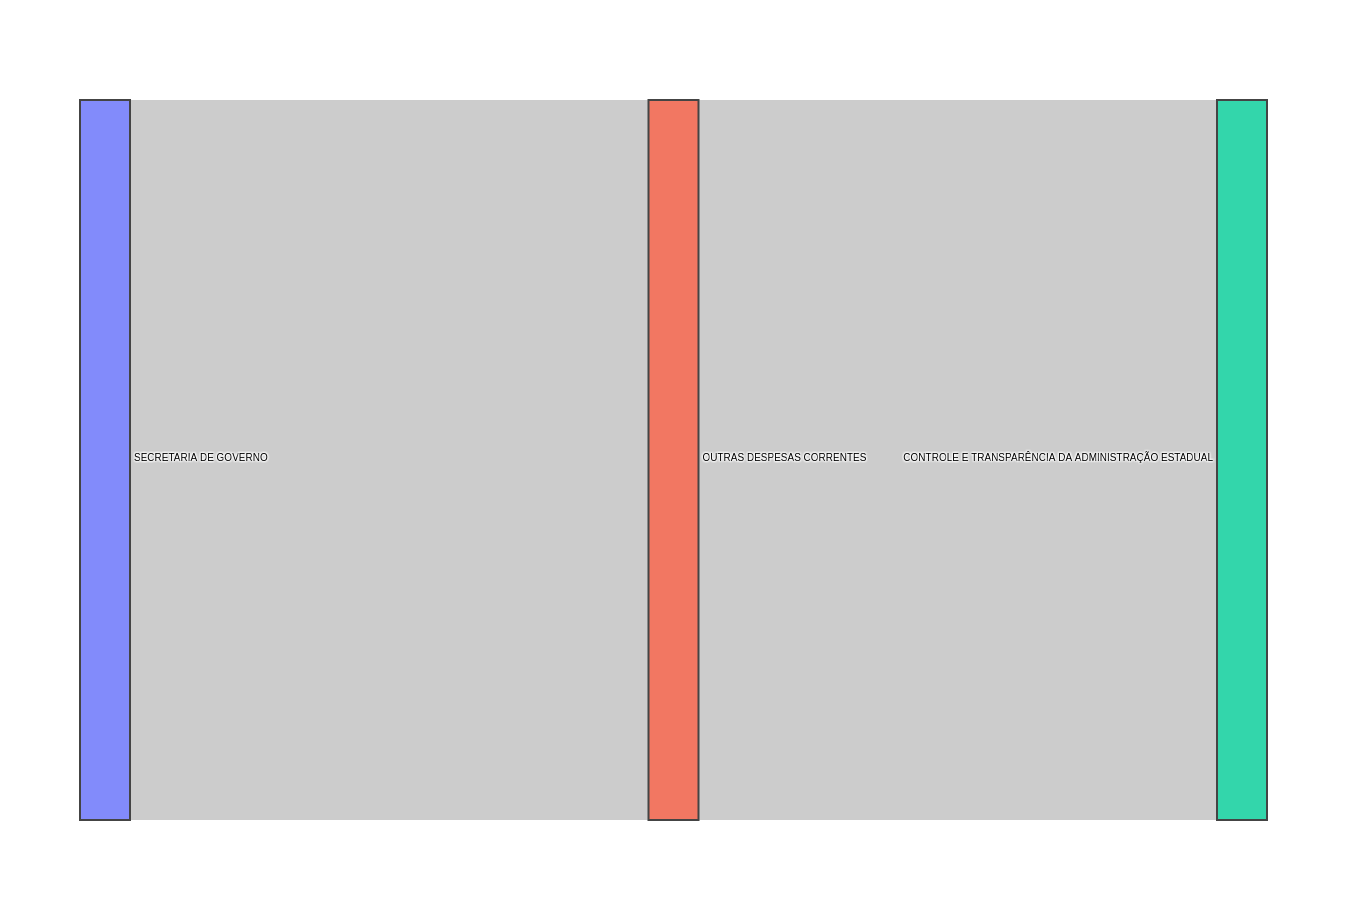

In [420]:
dd = df_ano.copy()

mask = (dd['programa'].str.contains('TRANSPARÊNCIA')) | (dd['acao'].str.contains('TRANSPARÊNCIA'))


# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','programa']
valor  = 'valor'

fig = sankey_plot(dd[mask],source,target,valor)


In [92]:
linkLabel

['An armed Predator mysteriously vanished in<br>Afghanistan about 5 hours into a flight. The skies<br>were clear and the aircraft was flying well above<br>a mountain range when the return satellite data<br>link was lost to Creech Air Force Base in Nevada.<br>The transponder signal was lost three minutes<br>later. Investigators concluded that there was no<br>evidence of bad weather, icing, fuel loss or pilot<br>error. A sergeant raised the possibility that the<br>aircraft could have had its satellite links hacked<br>or hijacked, saying: "If somebody else was on the<br>same frequencies, they could have taken over the<br>aircraft or just knocked it out completely."<br>Investigators found no evidence of hacking.<br><br>Damage: $3,900,000<br>',
 "An armed Predator crashed and skidded off the<br>runway after it landed nose-first and bounced in<br>the air seven times. Investigators blamed the<br>pilot, saying he misjudged the height above<br>touchdown and mistakenly thought the bouncing was<b